# Skin Cancer Detector with HAM10000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn import preprocessing

### LOAD DATA
The dataset contains 10015 images divided in two parts. The 'HAM10000_metadata.csv' contains the ground truth of the dataset. Here we can use this file to retrieve the images from the relative folders and also analyse what the images are.

In [2]:
path = '.'
file_name = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(file_name, na_values=['NA','?'])
disease_types = pd.unique(df['dx'])
print(disease_types)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


As you can see from the last print, there are 7 types of images classified in the dataset. Let's create a dictionary to better represent those diseases and then replace those with the full name of the skin patology.

In [3]:
images_type = {'bkl': 'Benign Keratosis', 'nv': 'Melanocytic Nevi',
                      'df': 'Dermatofibroma', 'mel': 'Melanoma',
                      'vasc': 'Vascular Lesions', 'bcc': 'Basal Cell Carcinoma',
                      'akiec': "Bowen's disease"}
images_type
df.replace(images_type.keys(), images_type.values(), inplace=True)
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign Keratosis,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign Keratosis,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign Keratosis,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign Keratosis,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign Keratosis,histo,75.0,male,ear


In [4]:
# We can observe also that the ages range, varies between 0 and 80.
# This information will be useful in the final analysis 
# because we could tell wheter if the age is an increasing 
# factor of skin cancer or not.
age_range = pd.unique(df['age'])
age_range

array([80., 75., 60., 70., 55., 85., 65., 40., 50., 45., 35.,  0., 30.,
       nan,  5., 25., 20., 10., 15.])

In [5]:
# It is also possible to locate where different tumors where found in the 
# patients
cancers_location = pd.unique(df['localization'])
cancers_location

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

The dataset has been developed during the last 20 years and most of the images have been classified manually using a process that in medicine is called 'Histopathology' (histo) which entails to microscopically analyse a small portion of the skin tissue and then classifying it accordigly. There are also images which has been classified by the use of a tool called Cofocal Microscopy (cofocal) which allowed medicians to correctly identify where there's a disease and where it's not. Finally the data contains also a series of images that have not been classified rigorously, denoted by 'follow_up' (data that needs follow-up examination) and 'consensus' data that has been classified by the consensus of a medician. Since these last three categories do not represent a rigorous result, we decided to exclude them from the scope of the analysis.

In [6]:
classification_type = pd.unique(df['dx_type'])
print(classification_type)
# Drop the rows that have the 'consensus' or 'follow_up' value
# in the column 'dx_type'
indexes_consensus = df[df['dx_type'] == 'consensus'].index
indexes_follow_up = df[df['dx_type'] == 'follow_up'].index
df = df.drop(indexes_consensus)
df = df.drop(indexes_follow_up)
df = df.reset_index(drop=True)
classification_type = pd.unique(df['dx_type'])
print(classification_type)

['histo' 'consensus' 'confocal' 'follow_up']
['histo' 'confocal']


After having deleted the pieces of data that are not relevant for the analysis, we now check if there are any missing values.

In [7]:
df.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool

From the analysis, it appears that the column of the 'age' has some missing values. To solve this problem we decided to fill those missing values with the median value.

In [8]:
median = df['age'].median()
df['age'] = df['age'].fillna(median)
df.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age             False
sex             False
localization    False
dtype: bool

Althought the dataset contains more that 10000 images, after the preprocessing we just eliminated almost half of them because they were not classified using a scientific method. Those images that have been deleted are indeed those whose were classified as 'consensus' and 'follow_up'.

After this brief pre-processing, we are left with 5409 images, each with a dimension of 450x600, and they are indeed RGB images.

Now it is useful to insert in the dataframe a column where for each image, locate the local path.

In [9]:
# Now it is useful to insert in the dataframe a column
# where for each image, locate the local path.
images_dir_path = '/Users/tommasocapecchi/Datasets/HAM10000/Images'
dataset = []
df

for image_name in df['image_id']:
    image_path = os.path.join(images_dir_path, image_name +'.jpg')
    df['img_path'] = image_path
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_path
0,HAM_0000118,ISIC_0027419,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...
1,HAM_0000118,ISIC_0025030,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...
2,HAM_0002730,ISIC_0026769,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...
3,HAM_0002730,ISIC_0025661,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...
4,HAM_0001466,ISIC_0031633,Benign Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Image...


In order to build a system capable to be trained and to give us results, it is crucial to encode the different types of skin cancer into  labels, to classify them. This is achieved using sklearn by the following code.

In [10]:
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(df['dx'])
df['target'] = labels
df[:10]

,lesion_id,image_id,dx,dx_type,age,sex,localization,img_path,target
0,HAM_0000118,ISIC_0027419,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
1,HAM_0000118,ISIC_0025030,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
2,HAM_0002730,ISIC_0026769,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
3,HAM_0002730,ISIC_0025661,Benign Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
4,HAM_0001466,ISIC_0031633,Benign Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
5,HAM_0001466,ISIC_0027850,Benign Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
6,HAM_0002761,ISIC_0029176,Benign Keratosis,histo,60.0,male,face,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
7,HAM_0002761,ISIC_0029068,Benign Keratosis,histo,60.0,male,face,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
8,HAM_0005132,ISIC_0025837,Benign Keratosis,histo,70.0,female,back,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1
9,HAM_0005132,ISIC_0025209,Benign Keratosis,histo,70.0,female,back,/Users/tommasocapecchi/Datasets/HAM10000/Image...,1


Now we would like to count the numbers of skin cancers according to each category to see if the dataset is well balanced or not.

Now we are going to load the images and adapt them to the best of our possibilities with respect to the size. The images in the dataset comes with two directories, part-1 and part-2. We are going to retrieve those images in two different variables and then unify in one big piece of data.

In [11]:
instances_cancer = df['target'].value_counts()
instances_cancer

4    2498
5    1113
1     835
0     514
2     327
6      67
3      55
Name: target, dtype: int64

From the results it appears that the dataset is highly imbalanced, thus we might consider some technique of expansion for those categories that suffer of a lack of instances with respect to those that have a high number instead.

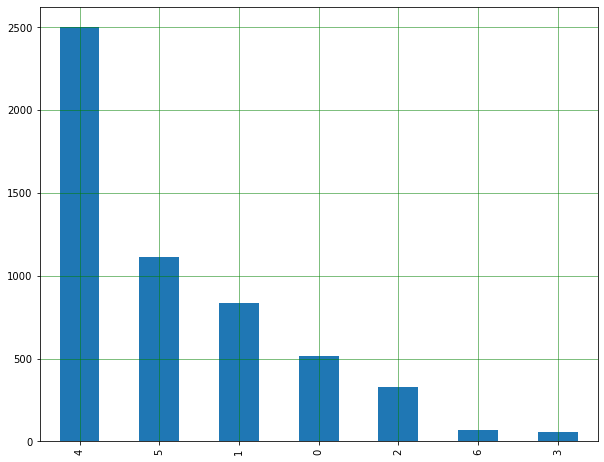

In [12]:
instances_cancer.plot(kind='bar', figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()